# Reproducibility Notebook — SF–SCF Polymer Brush Supercapacitor

This notebook accompanies the manuscript:

**“Electroconductive Polymer Brushes for Supercapacitors: Insights from Self-Consistent Field Modeling”**

It is intended to:
- document the SF–SCF parameter sets used in the paper,
- reproduce the main figures (EDL benchmark, brush profiles, $Q(\psi)$ curves, capacitance),
- serve as a fully reproducible Supplementary Information notebook.

Run the notebook from top to bottom to regenerate all figures used in the manuscript.


## Imports and Global Settings

In [1]:
import os
import pickle
from pathlib import Path
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd\
# %matplotlib inline
import matplotlib.pyplot as plt


from cap import Cap
from run import paramsHP, getCAPS  # core SF–SCF tools
from run import Brushes_mp       # we will either use this OR define local wrapper below

# --------------------------------------------------------------------
# Global plotting style
# --------------------------------------------------------------------
plt.rcParams.update({
    "figure.dpi": 120,
    "font.size": 11,
    "axes.labelsize": 11,
    "axes.titlesize": 11,
    "legend.fontsize": 9,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "lines.linewidth": 1.5,
})

# --------------------------------------------------------------------
# Paths
# --------------------------------------------------------------------
ROOT_DIR = Path(".").resolve()
DATA_DIR = ROOT_DIR / "data"
FIG_DIR = ROOT_DIR / "figures"

DATA_DIR.mkdir(exist_ok=True, parents=True)
FIG_DIR.mkdir(exist_ok=True, parents=True)

print("ROOT_DIR:", ROOT_DIR)
print("DATA_DIR:", DATA_DIR)
print("FIG_DIR :", FIG_DIR)


ROOT_DIR: /app/sf-scf-brush-supercapacitor
DATA_DIR: /app/sf-scf-brush-supercapacitor/data
FIG_DIR : /app/sf-scf-brush-supercapacitor/figures


## Data Production


In [2]:

params = {
    'phi': 0.0,
    'N': 200,
    'cna': 0.4,
    'D': 500,
    'timeout': 600,
    'alpha': 0.3,
    'sigma':3.5e-10,
}

paramsHP.update(params)
f = 0.0
t = 0.81
# t = 0.4

n=28



Alphas = np.round(np.linspace(f, t, n),3) # 
Alphas = np.round(np.linspace(f, t, 2*n-1),3) # Twice detailed  scan
# Alphas = np.round(np.linspace(f, t, 4*n-3),3) # Four times more detailed  scan
# Alphas = np.round(np.linspace(f, t, 8*n-7),3) #Eught times more detailed scan


# ------------------------------
# Parameter grids
# ------------------------------

phis = [0.0, 0.2, 0.4]       # grafting densities (chains/nm²)
# pKs = [1.0, 2.0, 3.0]
pKs  = [1.0]            # pK values
# cnas = [0.1, 0.4, 1.6]
cnas = [0.4, 1.6]       # salinities (mol/L)
# chis = [4.0, 2.0, 0.0]
chis = [0.0, 2.0, 4.0]            # Flory–Huggins parameter χ (in kT units)

def solve_brushes_in_parallel():
    # this function create instancies for all the chis, phis, pKs , anas and Alphasd and run all of them in a multiprocessor mode
    CAPS = []
    for pK in pKs :
        paramsHP.update({'pK': pK}) 
        for cna in cnas:
            paramsHP.update({'cna': cna})    
            for chi in chis:
                paramsHP.update({'chi': chi})
                paramsHP.update({'chi_subano': 5.0})
                for phi in phis:
                    paramsHP.update({'phi': phi})    
    
                    for alpha in Alphas:
                        paramsHP.update({'alpha': alpha})    
                        # pprint.pprint(paramsHP)
                        Brush = Cap(**paramsHP)
                        CAPS.append(Brush)
    
    # parameters dictionary for HomoPolymer
    
    
    
    Brushes_mp(CAPS)
# solve_brushes_in_parallel()

In [3]:



# ------------------------------
# File & directory setup
# ------------------------------

PICKLE_FILE = "data_CAPS.pkl"

DATA_DIR = "data"

os.makedirs(DATA_DIR, exist_ok=True)

# ------------------------------
# Load existing CAPSHL (if any)
# ------------------------------

if os.path.exists(PICKLE_FILE):
    with open(PICKLE_FILE, "rb") as f:
        CAPSHL = pickle.load(f)
    print(f"Loaded {len(CAPSHL)} entries from {PICKLE_FILE}")
else:
    CAPSHL = getCAPS(pKs, cnas, chis, phis, Alphas, mp=True)
    print("No existing pickle found. Starting with an empty CAPSHL dict.")


with open(PICKLE_FILE, "wb") as f:
    pickle.dump(CAPSHL, f)

print(f"\nCAPSHL now contains {len(CAPSHL)} entries and was saved to {PICKLE_FILE}")


Loaded 19 entries from data_CAPS.pkl

CAPSHL now contains 19 entries and was saved to data_CAPS.pkl


In [4]:
len(CAPSHL['pK1.0cna0.4chi0.0phi0.0'])


28

## Figure 2a Electric Double Layer in a Bare Half-Cell

This section will generate:
- (a) Na$^+$ and Cl$^-$ density profiles + potential near a bare electrode.
- (b) Stored ionic charge $Q$ vs surface potential $\psi_0$ for different
  salt concentrations.


Loaded: CapbbkGi6sLdmqMVxj55XCWyF
Loaded: CapPkvYeyuFfRVuEWpHgMpj9A
Loaded: CapGzJDNUfgoVEms7pszy9D43


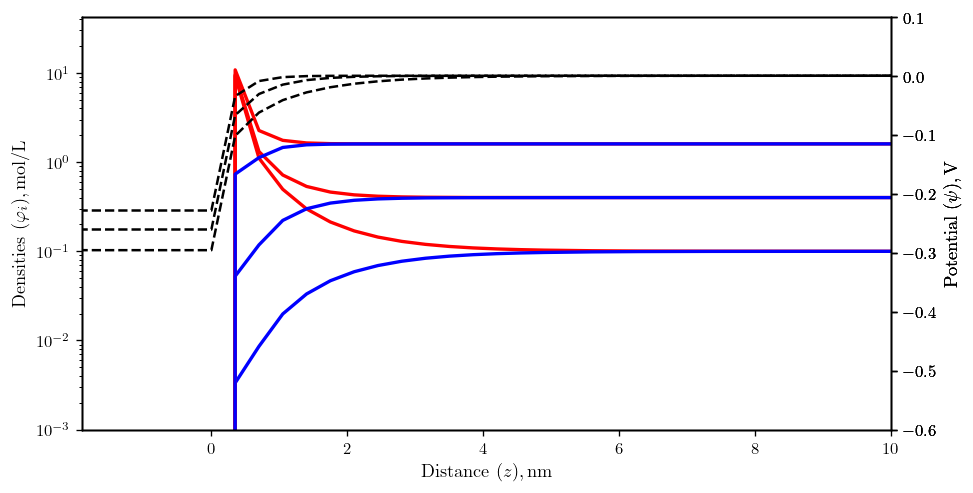

In [5]:
# Figure 2.1 generation (Jupyter version)

from cap import Cap
import os

# Salt concentrations to simulate
CSs = [0.1, 0.4, 1.6]

cells = []
ax = None
paramsHP.update({"phi": 0.0})
paramsHP.update({"alpha": 0.3})

for cna in CSs:
    # Update NaCl concentration
    paramsHP.update({"cna": cna})

    # Create simulation cell
    cell = Cap(**paramsHP)

    # Load precomputed results
    # print(cell.fname)
    cell.loadData()
    
    # Compute density and potential profiles
    cell.getProfiles()

    cells.append(cell)
    print(f"Loaded: {cell.fname}")

    # Overlay plots from each simulation
    ax, output_pdf_path = cell.plotSelectedProfiles(
        selected_lines=["Na", "Cl", "potential"],
        x_min=-1.9,
        x_max=10,
        ax=ax,
        add_title = False,
        show=False
    )

# Final figure
fig = ax.get_figure()

## Figure 2b — Stored Charge \( Q(\psi) \) for a Bare Planar Electrode

This section reproduces panel **(b)** of Figure 2 from the manuscript.  
For a bare planar electrode in aqueous NaCl solution, we compute the total
excess ionic charge

$$
Q = Q_{\mathrm{Na}^+}^{\mathrm{ex}} - Q_{\mathrm{Cl}^-}^{\mathrm{ex}},
$$

as a function of the surface potential $\psi$ for several bulk
salinities ($c_s = 0.1,\; 0.4,\; 1.6$ mol/L).  
The resulting $Q(\psi$ curves illustrate two key theoretical limits:

1. **Gouy–Chapman regime (low potential).**  
   The initial slope increases approximately as  
   $C_{\mathrm{GC}} \propto \sqrt{c_s}$, consistent with classical
   Poisson–Boltzmann predictions for a symmetric 1:1 electrolyte.

2. **Helmholtz saturation regime (high potential).**  
   All curves converge toward a common asymptotic slope corresponding to the
   ideal Helmholtz capacitance  
   $$
   C_{\mathrm{H}} \approx \varepsilon_0 \varepsilon_r / \delta
   \approx 1.7\ \mathrm{F/m^2},
   $$
   where $\delta \sim 0.4\,\mathrm{nm}$ represents the closest approach of
   hydrated ions to the electrode.

These curves serve as the **baseline empty-layer response**, used throughout the
manuscript as a reference when quantifying the enhanced charge storage produced
by polymer-brush-modified electrodes (Section 3).


Figure saved as figures/Figure2.2.pdf and figures/Figure2.2.svg


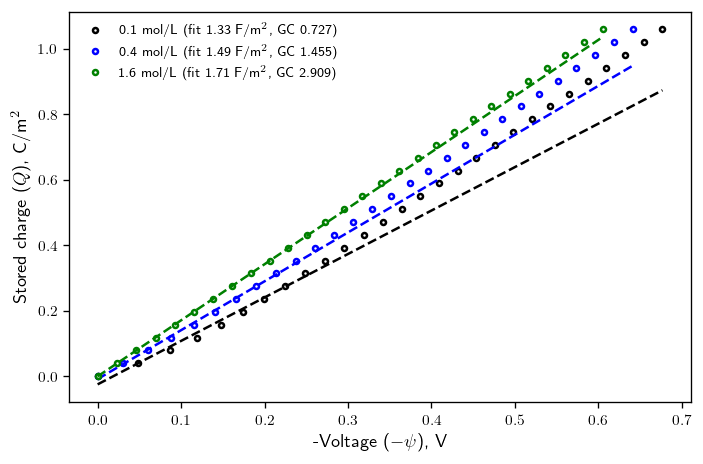

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Helper: Least squares linear regression ---------------------------------
def least_squares_fit(x, y):
    """
    Fit a straight line y = m x + b to data (x, y).

    Returns
    -------
    m : float
        Slope of the best-fit line.
    b : float
        Intercept of the best-fit line.
    """
    m, b = np.polyfit(x, y, 1)
    return m, b


# --- Parameter sets for bare EDL cases ---------------------------------------
pKs  = [1.0]
chis = [0.0]
phis = [0.0]

pK  = 1.0
chi = 0.0
phi = 0.0

cnas = [0.1, 0.4, 1.6]  # salt concentrations (mol/L)

# Collect all double-layer (no brush) CAP objects
CAPSDL = {}
for cna in cnas:
    key = f"pK{pK}cna{cna}chi{chi}phi{phi}"
    # try to reuse already computed entries from CAPSHL if available
    if "CAPSHL" in globals() and key in CAPSHL:
        CAPSDL[key] = CAPSHL[key]
    else:
        new_caps = getCAPS([pK], [cna], [chi], [phi], Alphas, mp=True)
        CAPSDL.update(new_caps)
        CAPSHL.update(new_caps)
        with open(PICKLE_FILE, "wb") as f:
            pickle.dump(CAPSHL, f)
# Increase timeout for the SF-SCF runs, if needed
paramsHP.update({"timeout": 60})

# --- Plot setup ---------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

colors = ["black", "blue", "green"]

epsilon0 = 8.854e-12  # F/m, vacuum permittivity
z = 1                 # ionic valence (monovalent ions)

# Loop over all double-layer cases
for i, (key, CAPS) in enumerate(CAPSDL.items()):
    # Ensure all CAPS have theta and profiles computed
    for c in CAPS:
        c.getTheta()
        c.getProfiles()

    # Excess adsorption for Na+ and Cl-
    ThetaNa = np.array([c.thetaNa_exc for c in CAPS])
    ThetaCl = np.array([c.thetaCl_exc for c in CAPS])

    # Net excess charge (dimensionless in internal units)
    Theta = ThetaNa - ThetaCl

    # Representative Cap for constants
    c0 = CAPS[0]

    # Convert to C/m^2
    unit = c0.electron / (c0.sigma**2)  # Coulomb/m^2 per unit Theta
    Theta = Theta * unit

    # Voltage array
    Voltage = np.array([c.V for c in CAPS])

    # Optional mask to remove unphysical/too-large data
    mask = Theta < 1000
    Theta = Theta[mask]
    Voltage = Voltage[mask]

    # x-axis: -Voltage (as in manuscript convention)
    x = -Voltage
    y = Theta

    # --- Linear fit in a small low-voltage window ----------------------------
    n_fit = min(10, len(Theta))  # guard if we have fewer than 10 points
    Theta4fit = Theta[:n_fit]
    Voltage4fit = Voltage[:n_fit]

    m_fit, b_fit = least_squares_fit(-Voltage4fit, Theta4fit)
    y_fit = m_fit * x + b_fit

    # --- Gouy–Chapman low-voltage capacitance --------------------------------
    # Debye length r_D (same expression as in the manuscript)
    rD = (
        c0.epsilon * epsilon0 * c0.kT
        / (2 * c0.Navogadro * (c0.cna / 0.1**3) * z * c0.electron**2)
    ) ** 0.5
    # Capacitance in Gouy-Chapman model at low voltage
    C_GC_low = c0.epsilon * epsilon0 / rD  # F/m^2

    

    # --- Plot data and fit ----------------------------------------------------
    color = colors[i % len(colors)]
    ax.plot(
        x,
        y,
        "o",
        label=fr"{c0.cna} mol/L (fit {m_fit:.2f} F/m$^2$, GC {C_GC_low:.3f})",
        color=color,
        lw=0,
        markersize=3,
        markerfacecolor="white",
        markeredgewidth=1.5,
    )

    ax.plot(
        x,
        y_fit,
        "--",
        color=color,
        lw=1.5,
    )

    # Optional: uncomment if you want values printed in the notebook output
    # print(
    #     f"c_na = {c0.cna} mol/L: "
    #     f"C_fit = {m_fit:.3f} F/m^2, "
    #     f"C_GC_low = {C_GC_low:.3f} F/m^2, "
    #     f"r_D = {rD:.3e} m"
    # )

# --- Axis labels, legend, layout ---------------------------------------------
ax.set_xlabel(r"-Voltage ($-\psi$), V")
ax.set_ylabel(r"Stored charge ($Q$), C/m$^2$")
ax.legend(fontsize=8, frameon=False)
ax.tick_params(labelsize=9)

fig.tight_layout()

# --- Save Figure 2.2 ---------------------------------------------------------
os.makedirs("figures", exist_ok=True)
figname = "figures/Figure2.2"
fig.savefig(figname + ".pdf")
fig.savefig(figname + ".svg")
print(f"Figure saved as {figname}.pdf and {figname}.svg")


## Figure 3 — Polymer-Brush-Modified Electrode: Density Profiles

This section reproduces **Figure 3** of the manuscript, showing the spatial
distributions of polymer segments, charged monomers, chain ends, and mobile
ions within an electroconductive polymer brush grafted to a planar electrode.

The SF–SCF model resolves the one-dimensional density profiles $\varphi_i(z)$ for all species (polymer, Na$^+$, Cl$^-$, solvent) as a function of the
distance $z$ from the electrode.

We examine three representative cases:

1. **Good solvent ($\chi = 0$), low surface charge ($\alpha = 0.13$ C/m$^2$)**  
   - The brush is uniformly swollen over $\sim 40$ nm.  
   - Only a small fraction of monomers is in the reduced (charged) state.  
   - Na$^+$ counterions penetrate throughout the brush.

2. **Good solvent ($\chi = 0$), high surface charge ($\alpha = 0.39$ C/m$^2$)**  
   - Electrostatic charging increases the density of reduced monomers.  
   - Counterion uptake rises substantially.  
   - Chain ends shift outward, indicating additional chain stretching.

3. **Moderately poor solvent ($\chi = 2$), high surface charge ($\alpha = 0.39$ C/m$^2$)**  
   - The brush exhibits a **collapsed inner core** near the substrate and a swollen outer region.  
   - This microphase-separated structure reflects competition between
     hydrophobic interactions and electrostatic swelling.  
   - The collapse–swelling coexistence is central to the capacitance peaks
     discussed in Section 3.3.

Each plot displays:
- **total polymer density** (gray),  
- **charged segment density** (black),  
- **chain-end distribution** (green dashed),  
- **Na$^+$** (red) and **Cl$^-$** (blue) profiles,  
- **electrostatic potential** (black dashed, secondary axis).

Together, these profiles show how solvent quality and redox charging control
the internal structure of the polymer brush and its ability to store charge
volumetrically.


### Figure 3a

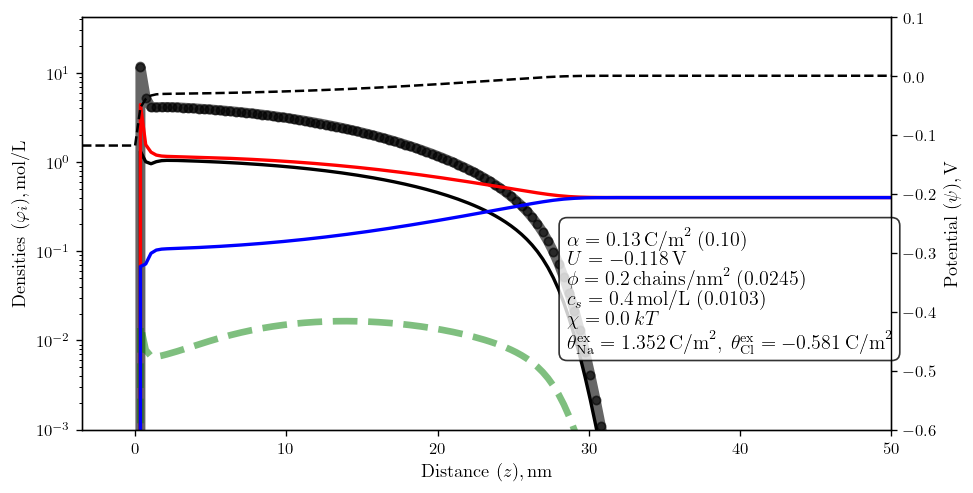

In [7]:
params = {
    "alpha": 0.1,
    'phi': 0.2,
    'chi': 0.0,
    'cna': 0.4,
}
paramsHP.update(params)

ax = None


Brush = Cap(**paramsHP)
Brush.loadData()
Brush.getProfiles()
str(Brush)
ax, output_pdf_path = Brush.plotSelectedProfiles(
    selected_lines=['Brush', 'charged', 'Ae', 'Na', 'Cl', 'potential'], 
    x_max = 50, y_min=1e-3)
fig = ax.get_figure()




### Figure 3b

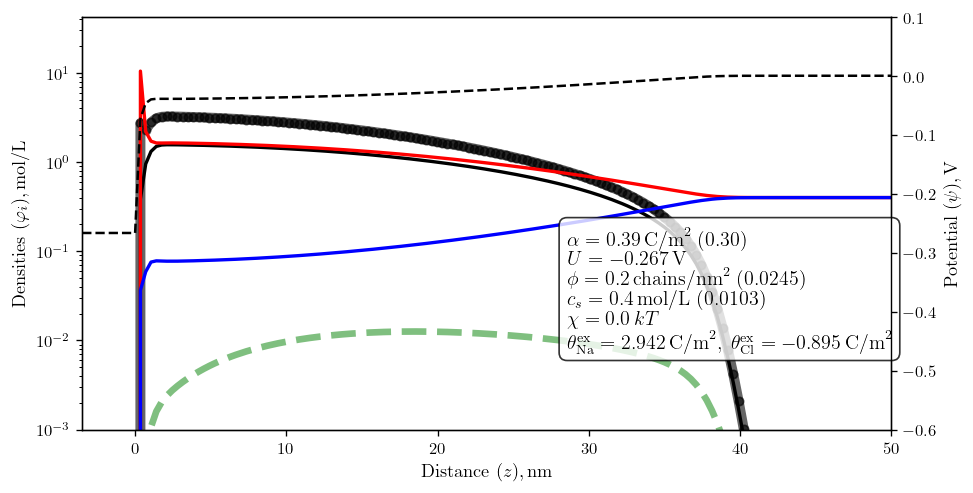

In [8]:
ax = None
alpha = 0.3
paramsHP.update({'alpha': alpha})

Brush = Cap(**paramsHP)
Brush.loadData()
# Cell.getTheta()
Brush.getProfiles()    # Cell.
str(Brush)
ax, output_pdf_path = Brush.plotSelectedProfiles(
    selected_lines=['Brush', 'charged', 'Ae', 'Na', 'Cl', 'potential'], 
    x_max = 50, y_min=1e-3)
fig = ax.get_figure()


### Figure 3c

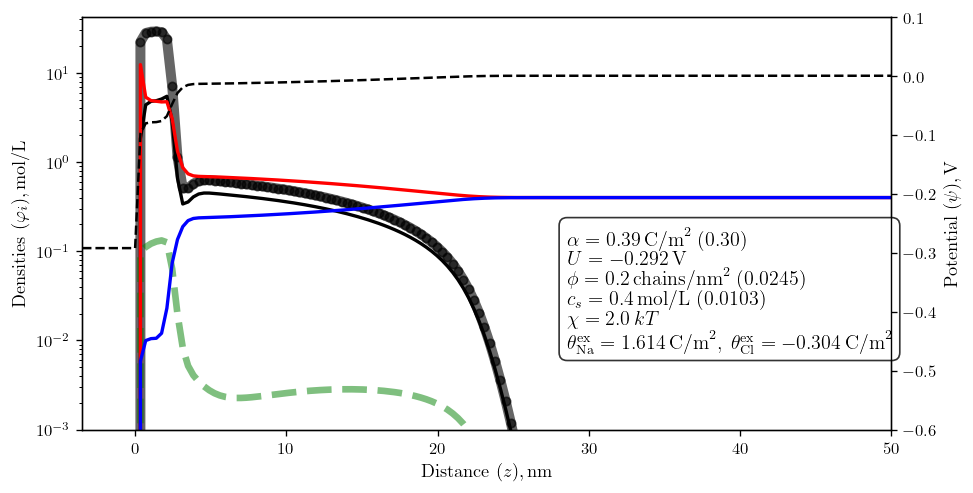

In [9]:
ax = None

chi = 2.0
paramsHP.update({'alpha': alpha})
paramsHP.update({'chi': chi})

Brush = Cap(**paramsHP)
Brush.loadData()
# Cell.getTheta()
Brush.getProfiles()    # Cell.
str(Brush)
# Cell.plotSelectedProfiles(selected_lines=['Na', 'Cl', 'H3O', 'OH', 'potential', 'subano'], y_min = 1e-8)
# ax = Cell.plotSelectedProfiles(selected_lines=['Na', 'Cl', 'potential', 'subano'], x_max = 20, ax = ax)
ax, output_pdf_path = Brush.plotSelectedProfiles(
    selected_lines=['Brush', 'charged', 'Ae', 'Na', 'Cl', 'potential'], 
    x_max = 50, y_min=1e-3)
fig = ax.get_figure()


## Figure 4 — Charge–Potential Curves for Polymer-Brush-Modified Electrodes

This section reproduces **Figure 4** of the manuscript, showing how the total
excess ionic charge $Q$ stored within the polymer brush varies with surface
potential $\psi$ for different solvent qualities and salinities.

For each parameter set, the SF–SCF simulations compute the net excess charge

$$
Q = Q_{\mathrm{Na}^+}^{\mathrm{ex}} - Q_{\mathrm{Cl}^-}^{\mathrm{ex}},
$$

where $Q_i^{\mathrm{ex}}$ is the integrated excess (or depletion) of species $i$
relative to the bulk concentration.

We compare the brush-modified curves against the **bare-electrode
baseline**, shown as thin straight lines.  
These reference curves correspond to the Helmholtz capacitance limit of the
empty electrochemical interface and serve as a benchmark for evaluating the
enhancement provided by polymer brushes.

The plotted cases include:
- two salinities, $c_s = 0.4$ and $1.6$ mol/L,
- several solvent qualities, $\chi = 0, 2, 4$,
- a fixed grafting density $\phi = 0.20$ chains/nm$^2$.

Key trends:

1. **Good solvent ($\chi = 0$).**  
   The brush is fully swollen, enabling volumetric counterion uptake.
   The $Q(\psi)$ curve has a steeper initial slope than the bare electrode,
   indicating enhanced differential capacitance.

2. **Moderately poor solvent ($\chi = 2$).**  
   A sigmoidal $Q(\psi)$ curve appears:
   - At low $\psi$, the brush is collapsed and stores little charge.  
   - At intermediate $\psi$, the brush swells, resulting in a rapid increase in $Q$
     and a pronounced capacitance peak.  
   - At high $\psi$, saturation is reached and the slope approaches the baseline.

3. **Strongly poor solvent ($\chi = 4$).**  
   The $Q(\psi)$ response becomes step-like, with plateaus separated by sharp
   jumps in $Q$.  
   These discontinuities correspond to **layer-by-layer erosion** of the
   collapsed inner core, consistent with the structural snapshots shown in
   Figure 5.

Together, these curves demonstrate how hydrophobicity, ion penetration, and
electrostatic swelling combine to produce the large capacitance enhancements
characteristic of electroconductive polymer brushes.


Figure saved as figures/Figure4_QV_brush.pdf and figures/Figure4_QV_brush.svg


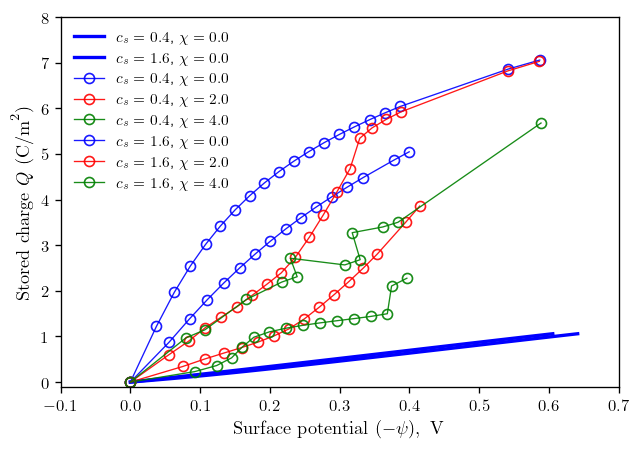

In [10]:
from cap import Cap
import os
from run import plotQV, getCAPS

# Color palette for different chi values
palette = [
    "blue", "red", "green", "orange", "purple", "brown",
    "cyan", "magenta", "olive", "teal", "navy", "maroon"
]

# Parameter sets
phis = [0.0, 0.2]     # grafting densities (chains/nm²)
pKs  = [1.0]          # pK values
cnas = [0.4, 1.6]     # salinities (mol/L)
chis = [0.0, 2.0, 4.0]     # Flory–Huggins χ (in kT units)

# We want a single figure / axes reused by all curves
fig, ax = None, None

# For phi = 0 (bare electrode), only plot once per cna
zero_phi_plotted = set()

for pK in pKs:
    for phi in phis:
        for cna in cnas:
            for i, chi in enumerate(chis):
                linestyle = 'auto'
                # For the bare interface (phi = 0), only plot one curve per cna
                if phi == 0:
                    linestyle = 'line'
                    if cna in zero_phi_plotted:
                        continue

                key = f"pK{pK}cna{cna}chi{chi}phi{phi}"

                # If this case is missing, compute it and update CAPSHL
                if key not in CAPSHL:
                    new_caps = getCAPS([pK], [cna], [chi], [phi], Alphas, mp=True)
                    CAPSHL.update(new_caps)

                color = palette[i % len(palette)]

                fig, ax = plotQV(
                    CAPSHL[key],
                    label=rf'$c_s = {cna}$, $\chi = {chi}$',
                    color=color,
                    ylim=[-0.1, 8],
                    xlim=[-0.1, 0.7],
                    ax=ax,        # reuse same axes
                    linestyle=linestyle
                )
                # fig, ax = plotQV(CAPSHL[key], label=key, color='black', linestyle='line')

                # Mark that we've already plotted phi=0 for this cna
                if phi == 0:
                    zero_phi_plotted.add(cna)

# Optional: save the resulting figure
os.makedirs("figures", exist_ok=True)
figname = "figures/Figure4_QV_brush"
fig.savefig(figname + ".pdf", bbox_inches="tight")
fig.savefig(figname + ".svg", bbox_inches="tight")
print(f"Figure saved as {figname}.pdf and {figname}.svg")


## Figure 5 — Conformation Snapshots and Capacitance Peaks in Polymer Brushes

This section reproduces **Figure 5** of the manuscript, which links the
charge–potential behavior of polymer-brush-modified electrodes to their
microscopic conformations obtained from SF–SCF simulations.

Figure 5 consists of two components:

---

### 1. Charge–potential curves with capacitance peaks

The top row shows the total stored charge $Q(\psi)$ for three representative
cases:

- $c_s = 0.4$ mol/L, $\chi = 2$
- $c_s = 1.6$ mol/L, $\chi = 2$
- $c_s = 0.4$ mol/L, $\chi = 4$

These curves exhibit:

- **smooth sigmoidal transitions** for the moderately poor solvent
  ($\chi = 2$),
- **step-like jumps** for the strongly hydrophobic case ($\chi = 4$).

The grey line shows the differential capacitance $C(\psi)$, highlighting sharp
capacitance peaks that occur where small voltage changes induce large changes
in $Q$.

---

### 2. Representative conformations at selected potentials

The lower panels show polymer, ion, and charged-segment density profiles
corresponding to the potentials marked by white circles in the top-row
$Q(\psi)$ curves.

These snapshots reveal the microscopic mechanisms responsible for the
capacitance peaks:

#### **Moderately poor solvent ($\chi = 2$)**  
- The brush initially forms a **collapsed inner core** near the substrate.  
- As $\psi$ increases, charged segments accumulate and Na$^+$ counterions
  invade the brush, gradually **eroding the collapsed core**.  
- The collapse–to–swollen transition occurs continuously, producing a broad,
  smooth capacitance maximum.

#### **Strongly poor solvent ($\chi = 4$)**  
- The brush forms a dense, solvent-poor slab near the electrode.  
- Swelling proceeds **layer by layer**:  
  each increase in potential destabilizes one additional lattice layer of the
  collapsed domain.  
- This produces **dis continuous jumps** in $Q(\psi)$, corresponding to sharp,
  almost divergent capacitance peaks.  
- Between jumps the brush remains collapsed, storing little charge.

---

### Interpretation

These results demonstrate that:

- Hydrophobic brushes undergo structural transitions under applied potential.  
- The eroding of the collapsed inner core strongly amplifies capacitance.  
- The nature of the transition (continuous vs. discontinuous) is governed by
  solvent quality ($\chi$).  

Figure 5 thus provides the mechanistic link between the **microscopic
brush conformation** and the **macroscopic capacitance enhancement** observed
in polymer-brush-modified electrodes.


Now we plot a random set of caps for different Alpha form the 

Figure saved as figures/Figure_column_singleQV_profiles.pdf and figures/Figure_column_singleQV_profiles.svg


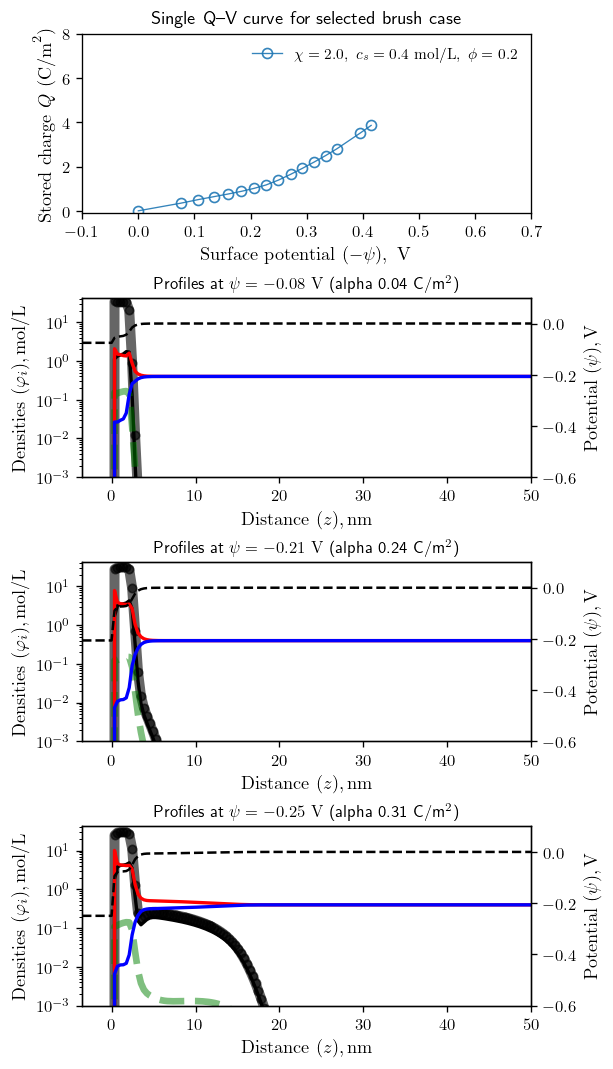

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os

# from run import plotTV  # your updated plotTV with 'linestyle' argument

# --- Choose the specific case to inspect -------------------------------------
pK_target   = 1.0
phi_target  = 0.20      # chains/nm²
cna_target  = 0.40      # mol/L
chi_target  = 2.0       # solvent quality

key = f"pK{pK_target}cna{cna_target}chi{chi_target}phi{phi_target}"

# Ensure CAPS for this key exist
if key not in CAPSHL:
    new_caps = getCAPS([pK_target], [cna_target], [chi_target], [phi_target], Alphas, mp=True)
    CAPSHL.update(new_caps)

CAPS = CAPSHL[key]

# --- Layout: 1 Q–V panel + N profile panels ----------------------------------
n_profiles = 3  # how many random profiles to show
total_rows = 1 + n_profiles

fig, axes = plt.subplots(
    nrows=total_rows,
    ncols=1,
    figsize=(5.0, 2.2 * total_rows),
    constrained_layout=True,
)

# Top axis for Q–V curve
ax_top = axes[0]

# --- Top panel: single Q(V) curve -------------------------------------------
fig, ax_top = plotQV(
    CAPS,
    label=fr"$\chi = {chi_target},\ c_s = {cna_target}\ \mathrm{{mol/L}},\ \phi = {phi_target}$",
    ax=ax_top,
    color="tab:blue",
    xlim=[-0.1, 0.7],
    ylim=[-0.1, 8.0],
    linestyle="markers",   # brush: line + markers
)

ax_top.set_title("Single Q–V curve for selected brush case", fontsize=11)

# --- Randomly choose Caps for profile plots ----------------------------------
np.random.seed(0)  # for reproducibility
indices = np.random.choice(len(CAPS), size=min(n_profiles, len(CAPS)), replace=False)

for i, idx in enumerate(indices, start=1):
    cap = CAPS[idx]
    ax_prof = axes[i]

    # Use the built-in profile plotting method, but draw onto our axis
    ax_prof, _ = cap.plotSelectedProfiles(
        selected_lines=['Brush', 'charged', 'Ae', 'Na', 'Cl', 'potential'],
        x_max=50,
        y_min=1e-3,
        ax=ax_prof,        # <--- important: plot into our subplot
        add_title = False,
    )

    ax_prof.set_title(fr"Profiles at $\psi = {cap.V:.2f}\ \mathrm{{V}}$ (alpha {cap.alpha* cap.to_coulombsperm2:.2f} C/m$^2$)", fontsize=10)
    
# Optionally save the whole column figure
os.makedirs("figures", exist_ok=True)
figname = "figures/Figure_column_singleQV_profiles"
fig.savefig(figname + ".pdf", bbox_inches="tight")
fig.savefig(figname + ".svg", bbox_inches="tight")
print(f"Figure saved as {figname}.pdf and {figname}.svg")

plt.show()
